In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel
import torch
import umap


from matplotlib.backends.backend_pdf import PdfPages

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from transformers import logging as transformer_logging
transformer_logging.set_verbosity_error()

In [4]:
model_paths = {
    3: "../../dnabert/3-new-12w-0",
    4: "../../dnabert/4-new-12w-0",
    5: "../../dnabert/5-new-12w-0",
    6: "../../dnabert/6-new-12w-0"
}

In [5]:
# Load k-mer data
def load_kmer_data():
    notebook_dir = os.getcwd()
    data_path = os.path.abspath(os.path.join(notebook_dir, "..", "..", "data", "enhancer_identification"))
    
    if not os.path.isdir(data_path):
        raise FileNotFoundError(f"Data directory not found: {data_path}")
        
    files = glob.glob(os.path.join(data_path, "*-mer_identification_train.txt"))
    
    data = {}
    for file in files:
        kmer_type = os.path.basename(file).split("_")[0]
        k = int(kmer_type.split("-")[0])
        
        if k in model_paths:
            df = pd.read_csv(file, sep='\t', header=None, names=['sequence', 'label'])
            data[k] = df
            print(f"Loaded {k}-mer data")
    return data

# Load the corresponding model and tokenizer
def load_model_and_tokenizer(k):
    model_path = model_paths[k]
    print('Loading model:', model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertModel.from_pretrained(model_path, num_labels=1).to(device)
    model.eval()
    return tokenizer, model


In [6]:
def get_bert_embeddings(sequences, tokenizer, model, device, batch_size=64):
    embeddings_list = []

    for i in range(0, len(sequences), batch_size):
        # Batch the sequences
        batch_sequences = sequences[i:i + batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch_sequences, padding=True, truncation=True, max_length=200, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        # Forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Extract embeddings and attention mask
        embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
        attention_mask = inputs["attention_mask"]  # Shape: (batch_size, seq_len)
        
        # Exclude [CLS] and [SEP] tokens
        cls_token_id = tokenizer.cls_token_id
        sep_token_id = tokenizer.sep_token_id
        exclude_mask = (inputs["input_ids"] != cls_token_id) & (inputs["input_ids"] != sep_token_id)
        
        # Update attention mask to exclude [CLS], [SEP], and padding tokens
        attention_mask = attention_mask * exclude_mask
        
        # Compute weighted sum of embeddings based on attention mask
        sum_embeddings = (embeddings * attention_mask.unsqueeze(-1)).sum(dim=1)  # Shape: (batch_size, hidden_dim)
        
        # Count valid tokens for averaging
        valid_token_counts = attention_mask.sum(dim=1).unsqueeze(-1)  # Shape: (batch_size, 1)
        
        # Avoid division by zero by replacing zeros with ones temporarily
        valid_token_counts = valid_token_counts.masked_fill(valid_token_counts == 0, 1)
        
        # Compute average embeddings
        avg_embeddings = sum_embeddings / valid_token_counts  # Shape: (batch_size, hidden_dim)
        
        # Convert to numpy array and append to the list
        embeddings_list.append(avg_embeddings.cpu().numpy())
    
    # Concatenate all batches into a single array
    return np.vstack(embeddings_list)

In [7]:
data = load_kmer_data()

Loaded 6-mer data
Loaded 3-mer data
Loaded 4-mer data
Loaded 5-mer data


In [8]:
# Sort the data items based on the model keys
data = {k: v for k, v in sorted(data.items(), key=lambda item: item[0])}

# **t-SNE**

In [9]:
def visualize_tsne_subplot(ax, embeddings, labels, k):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    label_names = {0: "Non-Enhancer", 1: "Enhancer"}
    
    # Separate different label categories
    unique_labels = np.unique(labels)
    
    # Assign colors and markers based on labels
    colors = {0: 'blue', 1: 'red'}
    markers = {0: 's', 1: 'o'}

    # Loop through labels in reverse order to change legend order
    for label in unique_labels[::-1]:
        indices = np.where(labels == label)
        ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], 
                   label=label_names[label], alpha=0.5, color=colors[label], 
                   marker=markers[label])

    ax.set_title(f'{k}-mer')
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.legend(loc="upper right")

Loading model: ../../dnabert/3-new-12w-0
Loading model: ../../dnabert/4-new-12w-0
Loading model: ../../dnabert/5-new-12w-0
Loading model: ../../dnabert/6-new-12w-0


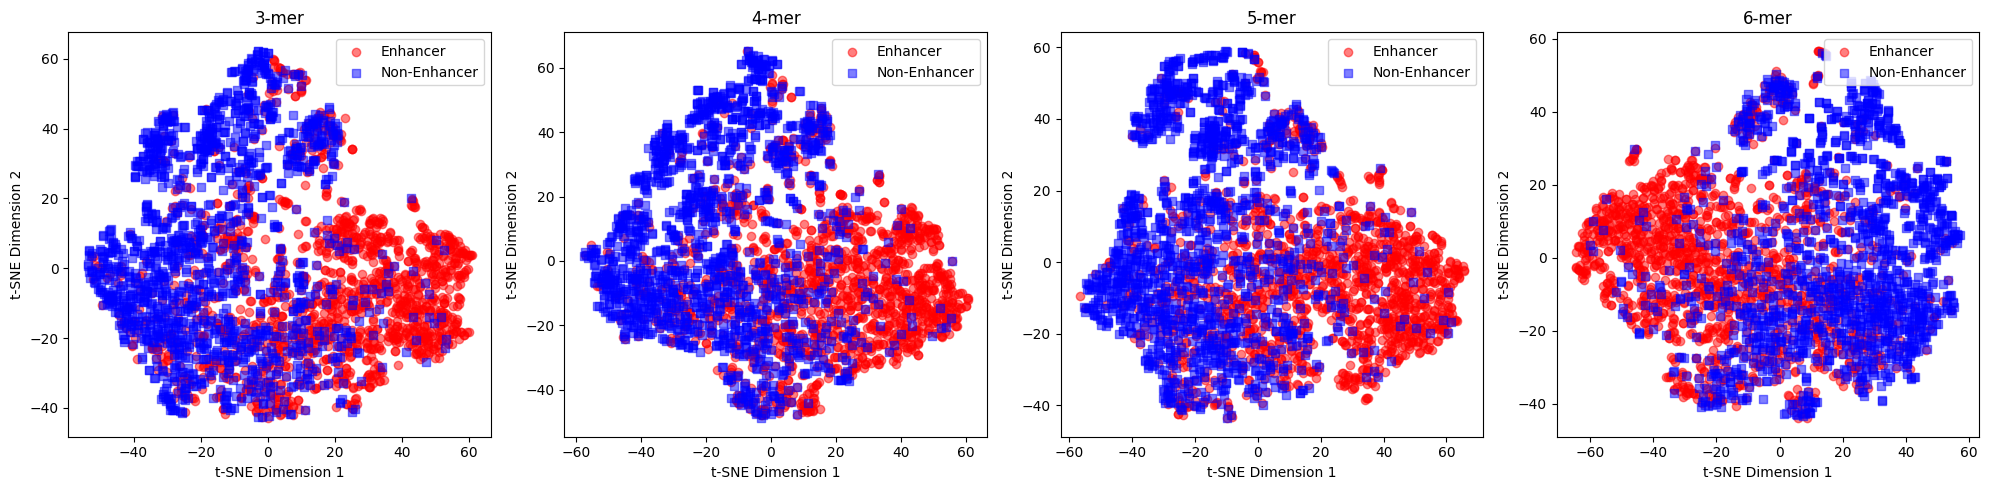

In [10]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()  # Flatten the grid 

for i, (k, df) in enumerate(data.items()):
    if i >= len(axes):  # Ensure we don not exceed the number of subplots
        break
    
    tokenizer, model = load_model_and_tokenizer(k)    
    embeddings = get_bert_embeddings(df['sequence'].tolist(), tokenizer, model, device)
    
    # Pass the current subplot axis to the visualization function
    visualize_tsne_subplot(axes[i], embeddings, df['label'].tolist(), k)

# Adjust layout to avoid overlap
plt.tight_layout()

with PdfPages('dnabert_tsne_visualizations.pdf') as pdf:
    pdf.savefig(fig)

plt.show()

# **UMAP**

In [11]:
def visualize_umap_subplot(ax, embeddings, labels, k):
    # Perform UMAP dimensionality reduction
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    umap_results = umap_reducer.fit_transform(embeddings)

    label_names = {0: "Non-Enhancer", 1: "Enhancer"}
    
    # Separate different label categories
    unique_labels = np.unique(labels)
    
    # Assign colors and markers based on labels
    colors = {0: 'blue', 1: 'red'}
    markers = {0: 's', 1: 'o'}

    # Loop through labels in reverse order to change legend order
    for label in unique_labels[::-1]:
        indices = np.where(labels == label)
        ax.scatter(umap_results[indices, 0], umap_results[indices, 1], 
                   label=label_names[label], alpha=0.5, color=colors[label], 
                   marker=markers[label])

    ax.set_title(f'{k}-mer')
    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")
    ax.legend(loc="upper right")

Loading model: ../../dnabert/3-new-12w-0


/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Loading model: ../../dnabert/4-new-12w-0


/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Loading model: ../../dnabert/5-new-12w-0


/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Loading model: ../../dnabert/6-new-12w-0


/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


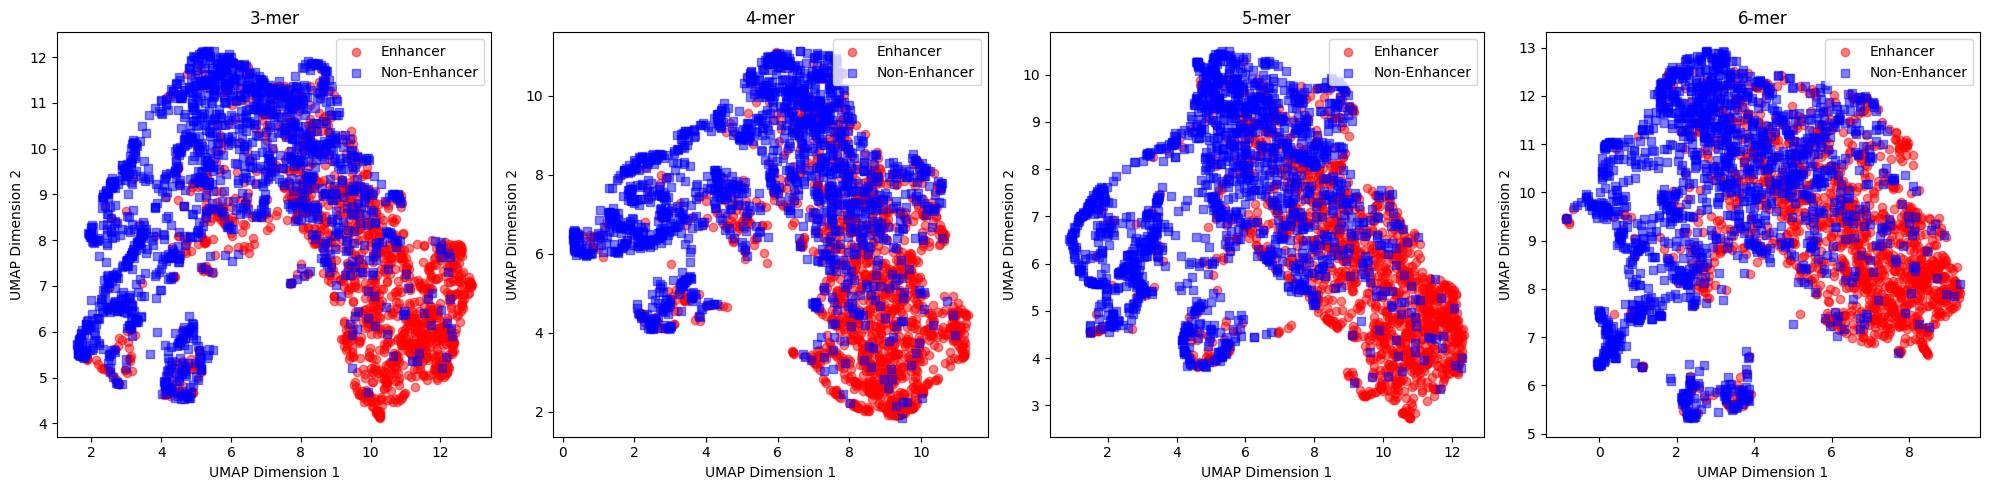

In [12]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()  # Flatten the grid 

for i, (k, df) in enumerate(data.items()):
    if i >= len(axes):  # Ensure we do not exceed the number of subplots
        break
    
    tokenizer, model = load_model_and_tokenizer(k)    
    embeddings = get_bert_embeddings(df['sequence'].tolist(), tokenizer, model, device)
    
    # Pass the current subplot axis to the visualization function
    visualize_umap_subplot(axes[i], embeddings, df['label'].tolist(), k)

# Adjust layout to avoid overlap
plt.tight_layout()

with PdfPages('dnabert_umap_visualizations.pdf') as pdf:
    pdf.savefig(fig)

plt.show()